## 前期准备

#### 设置运算设备

PyTorch中，tensor默认在CPU上存储和运算。若要将其转到GPU上，则可以使用.to('cuda')。要将已存储在GPU上的tensor转回CPU上，则可以使用.to('cpu')。

若有可用的GPU设备，则设置变量device为'cuda'，否则为'cpu'。对之后代码中所有数据和模型参数使用.to(device)，就可以把它们转到我们想要的设备上。

In [1]:
import torch

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

## 准备数据集

#### 导入数据集文件

若检测到未导入过数据集文件，则创建数据集存储路径，如果使用的是矩池云平台，可以将矩池云预置的数据集压缩文件解压至目标路径下。

In [3]:
import tarfile

In [4]:
import os
if not os.path.exists('../dataset/cifar-10-batches-py'):  # 检测路径下是否已存在文件，若否，则执行以下代码
    os.mkdir('data')  # 创建数据存储路径，即data文件夹
    with tarfile.open('/public/data/image/cifar10/cifar-10-batches-py.tar.gz') as tar:  # 矩池云上内置CIFAR10数据集压缩文件的存储路径
        tar.extractall(path='data')  # 将数据集压缩文件解压，并保存至data文件夹中

#### 创建训练集、测试集

先使用torchvision.datasets中内置的CIFAR10类，将数据集文件转换为PyTorch中的数据集，并对其中的图片数据施加一定的预处理。接下来，使用DataLoader将数据集转化为分批次的数据读取器，可直接用于训练。

In [5]:
import torchvision.transforms as transforms
import torchvision

In [6]:
batch_size = 128

In [7]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # 重塑为AlexNet所需的输入形状（ 32 * 32）
    transforms.ToTensor(),  # 转换为tensor（注意，此处的tensor默认在CPU上储存）
])

In [9]:
train_set = torchvision.datasets.CIFAR10(root='../dataset', train=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set,
                            batch_size=batch_size, shuffle=True,num_workers=12)  # 进行打乱

val_set = torchvision.datasets.CIFAR10(root='../dataset',
                            train=False, transform=transform)
val_loader = torch.utils.data.DataLoader(val_set,
                            batch_size=batch_size, shuffle=False, num_workers=12)  # 不进行打乱

#### 展示数据集样例

trainloader的格式比较特殊，直接使用trainloader[0]取其中第一个元素会报错。我们先将其转换为Python中的迭代器类型，再用next函数取其中第一个元素。

In [10]:
images, labels = next(iter(train_loader))  # 获取训练集第一个批次中的图片及相应标签
print(images.shape)
print(labels.shape)

torch.Size([128, 3, 32, 32])
torch.Size([128])


查看训练集第一个批次中的图片。

In [11]:
from matplotlib import pyplot as plt
from torchvision.utils import make_grid

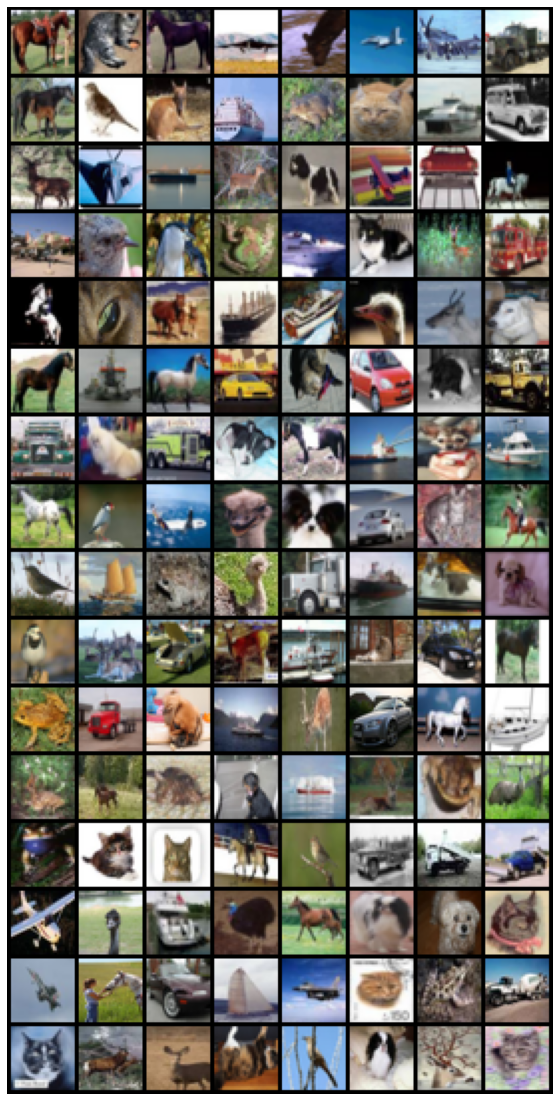

In [12]:
plt.figure(figsize=(12, 20))  # 设置画布大小
plt.axis('off')  # 隐藏坐标轴
plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))  # make_grid函数把多张图片一起显示，permute函数调换channel维的顺序
plt.show()

## 构建模型

# 6.1 AlexNet

借助PyTorch内置的nn.Sequential类构建模型。

In [13]:
import torch.nn as nn
import torch.nn.functional as F

In [14]:
class AlexNet(nn.Module):
    '''
    为定义Alexnet模型，继承nn.Module类，该类需要定义两个函数
    __init__:初始化，这里采用nn.Sequential建立卷积神经网络
    forward(self,x):定义前馈学习,x为输入的像素矩阵
    '''
    def __init__(self):
        super(AlexNet, self).__init__() ## 直接继承nn.Module的init
        ## 构建卷积层
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=3, stride=1, padding=1),  # [96, 32, 32 ]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),      # [96, 15, 15]

            nn.Conv2d(96, 256, 3, 1, 1), # [256, 15, 15]
            nn.ReLU(),
            nn.MaxPool2d(3, 2),      # [256, 7, 7]

            nn.Conv2d(256, 384, 3, 1, 1), # [384, 7, 7]
            nn.ReLU(),
            nn.Conv2d(384, 384, 3, 1, 1), # [384, 7, 7]
            nn.ReLU(),
            
            nn.Conv2d(384, 256, 3, 1, 1), # [256, 7, 7]
            nn.ReLU(),
            nn.MaxPool2d(3, 2,),  # [256, 3, 3]
        )

        ## 构建全连接层 
        self.fc = nn.Sequential(
            nn.Linear(2304, 4096), ## 2304为卷积层的输出维数
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 10)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)  ## 在卷积操作后，输出仍是tensor，需要进行flatten拉直，再接全连接层
        return self.fc(out)

In [15]:
from torchsummary import summary
## 需要预先下载，在终端输入 pip install torchsummary
IMSIZE = 32
alexnet_model = AlexNet().cuda()
summary(alexnet_model, (3, IMSIZE, IMSIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 32, 32]           2,688
              ReLU-2           [-1, 96, 32, 32]               0
         MaxPool2d-3           [-1, 96, 15, 15]               0
            Conv2d-4          [-1, 256, 15, 15]         221,440
              ReLU-5          [-1, 256, 15, 15]               0
         MaxPool2d-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 384, 7, 7]         885,120
              ReLU-8            [-1, 384, 7, 7]               0
            Conv2d-9            [-1, 384, 7, 7]       1,327,488
             ReLU-10            [-1, 384, 7, 7]               0
           Conv2d-11            [-1, 256, 7, 7]         884,992
             ReLU-12            [-1, 256, 7, 7]               0
        MaxPool2d-13            [-1, 256, 3, 3]               0
           Linear-14                 [-

## 模型训练

先定义几个训练中会用到的函数。

In [16]:
# 计算模型预测准确率
def accuracy(outputs, labels):
    preds = torch.max(outputs, dim=1)[1]  # 获取预测类别
    return torch.sum(preds == labels).item() / len(preds)  # 计算准确率

In [17]:
# 模型验证
def validate(model, val_loader):
    val_loss = 0
    val_acc = 0
    model.eval()
    
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # 将tensor切换到GPU存储模式
        outputs = model(inputs)  # 计算模型输出        
        loss = F.cross_entropy(outputs, labels)  # 计算交叉熵损失函数
        val_loss += loss.item()  # item方法提取出tensor中的数字       
        acc = accuracy(outputs, labels)  # 计算准确率
        val_acc += acc
    
    val_loss /= len(val_loader)  # 计算平均损失
    val_acc /= len(val_loader)  # 计算平均准确率
    return val_loss, val_acc

In [18]:
# 打印训练结果
def print_log(epoch, train_time, train_loss, train_acc, val_loss, val_acc):
    print(f"Epoch [{epoch+1}/{epochs}], time: {train_time:.2f}s, loss: {train_loss:.4f}, acc: {train_acc:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}")

In [19]:
# 模型训练
import time
def train(model, optimizer, train_loader, val_loader, epochs=1):
    train_losses = []; train_accs = [];
    val_losses = []; val_accs = [];
    model.train()
    
    for epoch in range(epochs):     
        train_loss = 0
        train_acc = 0     
        start = time.time()  # 记录本epoch开始时间
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # 将tensor切换到GPU存储模式
            optimizer.zero_grad()  # 将模型所有参数tensor的梯度变为0（否则之后计算的梯度会与先前存在的梯度叠加）
            outputs = model(inputs)  # 计算模型输出
            loss = F.cross_entropy(outputs, labels)  # 计算交叉熵损失函数
            train_loss += loss.item()  # item方法提取出tensor中的数字
            acc = accuracy(outputs, labels)  # 计算准确率
            train_acc += acc
            loss.backward()  # 调用PyTorch的autograd自动求导功能，计算loss相对于模型各参数的导数
            optimizer.step()  # 根据模型中各参数相对于loss的导数，以及指定的学习率，更新参数
        
        end = time.time()  # 记录本epoch结束时间
        train_time = end - start  # 计算本epoch的训练耗时
        
        train_loss /= len(train_loader)  # 计算平均损失
        train_acc /= len(train_loader)  # 计算平均准确率     
        val_loss, val_acc = validate(model, val_loader)  # 计算测试集上的损失函数和准确率
        
        train_losses.append(train_loss); train_accs.append(train_acc)
        val_losses.append(val_loss); val_accs.append(val_acc)
        print_log(epoch, train_time, train_loss, train_acc, val_loss, val_acc)  # 打印训练结果
    return train_losses, train_accs, val_losses, val_accs

输入参数epochs和lr，实施训练。

In [21]:
lr = 1e-4
optimizer = torch.optim.Adam(alexnet_model.parameters(), lr=lr)  # 设置优化器
epochs = 2
history = train(alexnet_model, optimizer, train_loader,
                val_loader, epochs=epochs)  # 实施训练

Epoch [1/2], time: 12.63s, loss: 1.2653, acc: 0.5366, val_loss: 1.1692, val_acc: 0.5744
Epoch [2/2], time: 12.58s, loss: 1.0994, acc: 0.6011, val_loss: 1.0969, val_acc: 0.6079


## 模型预测

从训练集中选取几张图片，使用模型做出预测，观察结果。

In [22]:
# 模型预测(给出的是预测类别的序号)
def predict(model, inputs):
    outputs = model(inputs.to(device))
    preds = torch.max(outputs, dim=1)[1]
    return preds

In [23]:
testiter = iter(val_loader)

每次对迭代器testiter执行next，就会取出其下一个元素。因此，多次运行以下代码块，即可测试不同的图片。

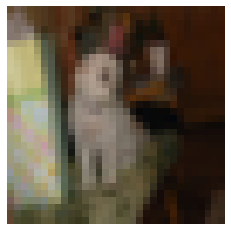

Prediction: dog


In [29]:
image = next(testiter)[0][0]
plt.axis('off')
plt.imshow(image.permute((1, 2, 0)))
plt.show()

pred = predict(alexnet_model, image.unsqueeze(dim=0))  # 由于模型接受的输入shape为4维（第1维为batch_size），因此需要使用unsqueeze函数在图片前面加一维
print('Prediction:', val_set.classes[pred])